In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import geopandas as gpd

import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import sys

sys.path.insert(0, "./../")
from FileManager import FileManager
from misc import rcsetup
rcsetup()


In [2]:
def get_color(x, cmap='hsv'):
    return plt.colormaps[cmap](x)

def darken_color(color, amount=0.33):
    amount = float(max(0.0, min(1.0, amount)))
    rgb = mpl.colors.to_rgb(color)
    hsv = mpl.colors.rgb_to_hsv(rgb)
    hsv[2] = max(0.0, hsv[2] * (1.0 - amount))
    return tuple(mpl.colors.hsv_to_rgb(hsv))

In [3]:
class Vocabulary:

    def __init__(self, word_counts):
        self.words = np.array([word for word, c in word_counts])
        self.counts = np.array([c for word, c in word_counts])
        self.word2token = {word:tok for tok, word in enumerate(self.words)}
        self.size = len(self.words)

    def get_count(self, word):
        if word not in self.word2token:
            return 0
        return self.counts[self.word2token.get(word)]

    def to_words(self, tokens):
        return " ".join([self.words[tok] for tok in tokens])

# Prepare word embeddings

In [4]:
VOCAB_SZ = 25_000
data_dir = os.path.join(os.getenv("DATASETPATH"), "enwiki", "min200")

data_fm = FileManager(data_dir)
word_counts = data_fm.load("word_counts.pickle")
vocab = Vocabulary(word_counts)

In [5]:
print(f"Computing M*... ", end="")
corpus_stats = data_fm.load("corpus_stats.pickle")
cL = corpus_stats["context_len"]
Cij, Crwij = corpus_stats["counts"], corpus_stats["counts_reweight"]
numcounts = Cij[:VOCAB_SZ, :VOCAB_SZ].sum()
Pij = Crwij[:VOCAB_SZ, :VOCAB_SZ] / (numcounts * (cL + 1)/2)
unigram = vocab.counts[:VOCAB_SZ] / vocab.counts[:VOCAB_SZ].sum()
PiPj = np.outer(unigram, unigram)
Mstar = 2*(Pij - PiPj)/(Pij + PiPj)
print("done.")

Computing M*... done.


In [6]:
def get_asym_embeds(M):
    M_gpu = torch.tensor(M, dtype=torch.float32).cuda()
    eigvals, eigvecs = torch.linalg.eigh(M_gpu)
    eigvals = eigvals.cpu().numpy().astype(np.float64)
    eigvecs = eigvecs.cpu().numpy().astype(np.float64)
    del M_gpu
    torch.cuda.empty_cache()
    
    signs = np.sign(eigvals)
    sort_idx = np.argsort(np.abs(eigvals))[::-1]
    eigvals = np.abs(eigvals)[sort_idx]
    signs = signs[sort_idx]
    eigvecs = eigvecs[:, sort_idx]
    embeds = eigvecs * np.sqrt(eigvals[None, :])
    return embeds, signs

embeds, signs = get_asym_embeds(Mstar)

# Get state boundaries (one-time download)

In [7]:
# import requests
# import zipfile
# from io import BytesIO

# r = requests.get("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip")
# z = zipfile.ZipFile(BytesIO(r.content))
# z.extractall("states50")

# States

In [8]:
with open("spacetime.txt") as f:
    data = f.read().strip().split("\n")

strip = lambda x: [y.strip() for y in x]

# spacetime = {}
current_category = None
state_names = []
lats, longs = [], []
state_idxs = []
for line in data:
    line = line.strip().lower()
    if line.startswith(":: "):
        current_category = line[3:].strip()
        continue
    assert current_category is not None
    if current_category != "states":
        continue
    places, latlong = strip(line.split(";"))
    lat, long = map(float, strip(latlong.split(" ")))
    places = strip(places.split("/"))
    token = places[0].replace(" ", "-")
    if token not in vocab.word2token:
        print(token)
        continue
    state_names.append(token)
    state_idxs.append(vocab.word2token.get(token))
    lats.append(lat)
    longs.append(long)
state_idxs = np.array(state_idxs)
state_names = [name.replace("-", " ") for name in state_names]
lats, longs = np.array(lats), np.array(longs)
N = len(state_idxs)
print(f"Found {len(state_idxs)} states")

Found 48 states


In [9]:
states50 = gpd.read_file("states50/cb_2018_us_state_20m.shp")
states50 = states50[~states50["NAME"].isin(["Alaska", "Hawaii", "Puerto Rico", "District of Columbia"])]
states50 = states50.sort_values("NAME").reset_index(drop=True)
states50["NAME"] = states50["NAME"].str.lower()

## Theory

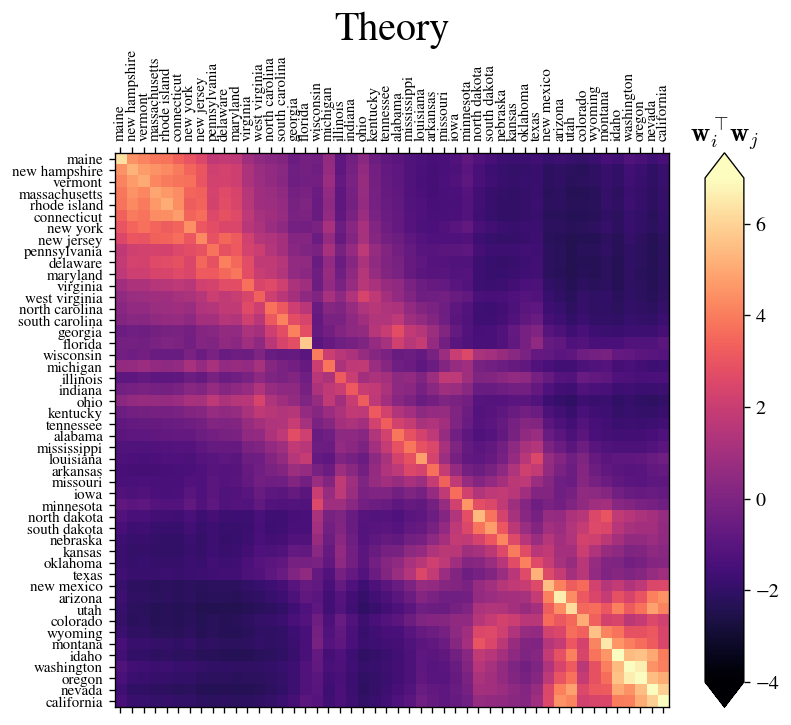

In [10]:
M_th = np.zeros((N, N))

lon_scale = 0.78   # continental US average
for i in range(lats.shape[0]):
    for j in range(i, lats.shape[0]):
        dlat = lats[i] - lats[j]
        dlon = longs[i] - longs[j]
        dist = np.sqrt(dlat**2 + (lon_scale * dlon)**2)
        M_th[i, j] = 10*np.exp(-dist/20)
        M_th[j, i] = M_th[i, j]
        
centering = np.eye(N) - np.ones((N, N))/N
M_th = centering @ M_th @ centering

fig, ax = plt.subplots(figsize=(7, 6))
im = ax.matshow(M_th, cmap="magma", aspect='equal', vmin= -4, vmax=7)
ax.set_xticks(np.arange(N))
ax.set_yticks(np.arange(N))
ax.set_xticklabels(state_names, rotation=90, fontsize=9)
ax.set_yticklabels(state_names, fontsize=9)
ax.set_aspect('equal')
ax.set_title("Theory", fontsize=24)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="7%", pad=0.3)
cax.set_title(r"$\mathbf{w}_i^\top \! \mathbf{w}_j$", pad=0, fontsize=16)
fig.colorbar(im, cax=cax, extend='both')

plt.show()

In [11]:
W_th, _ = get_asym_embeds(M_th)
mu = W_th.mean(axis=0, keepdims=True)
_, _, Vt = np.linalg.svd((W_th - mu), full_matrices=False)
embeds_th = (W_th - mu) @ Vt.T

## Word embedding

In [12]:
d_max = 25000
W_states = embeds[state_idxs, :d_max]

mu = W_states.mean(axis=0, keepdims=True)
_, _, Vt = np.linalg.svd((W_states - mu), full_matrices=False)
embeds_w2v_25k = (W_states - mu) @ Vt.T

In [13]:
d_max = 1000
W_states = embeds[state_idxs, :d_max]

mu = W_states.mean(axis=0, keepdims=True)
_, _, Vt = np.linalg.svd((W_states - mu), full_matrices=False)
embeds_w2v_1k = (W_states - mu) @ Vt.T

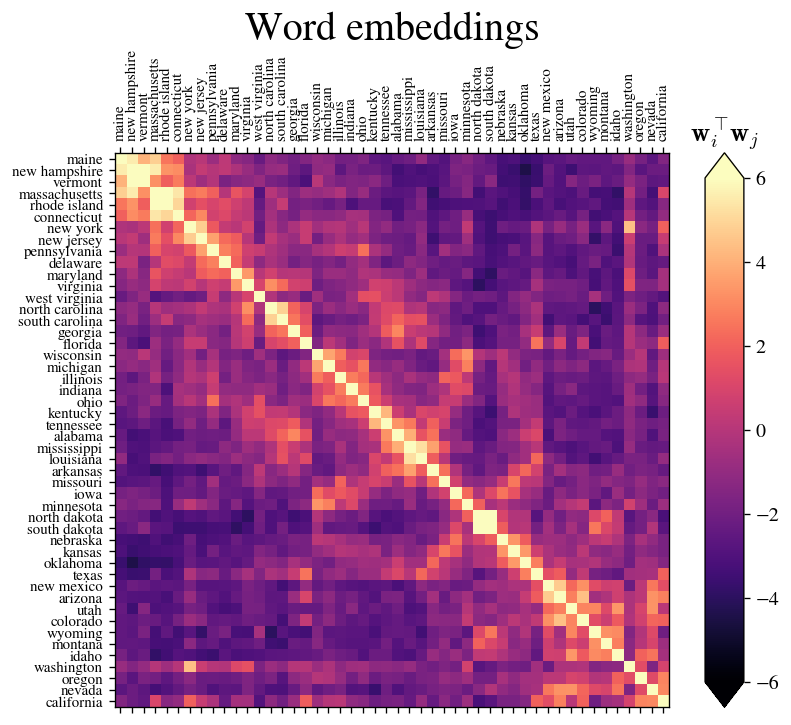

In [14]:
gram = embeds_w2v_25k @ embeds_w2v_25k.T

fig, ax = plt.subplots(figsize=(7, 6))
im = ax.matshow(gram, cmap="magma", aspect='equal', vmax=6, vmin=-6)
ax.set_xticks(np.arange(N))
ax.set_yticks(np.arange(N))
ax.set_xticklabels(state_names, rotation=90, fontsize=9)
ax.set_yticklabels(state_names, fontsize=9)
ax.set_title("Word embeddings", fontsize=24)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="7%", pad=0.3)
cax.set_title(r"$\mathbf{w}_i^\top \! \mathbf{w}_j$", pad=0, fontsize=16)
fig.colorbar(im, cax=cax, extend='both')

plt.show()

## Gemma 2 2B

In [15]:
data = np.load("lm_reps/gemma2b_states_contextualized.npy", allow_pickle=True).tolist()
layer = "layer_6"
reps = []
rep_idxs = []
for prompt, rep in data[layer].items():
    statename = " ".join(prompt.split()[6:]).lower()
    if statename not in state_names:
        continue
    reps.append(rep)
    rep_idxs.append(state_names.index(statename))
W_gemma = np.array(reps)
W_gemma = W_gemma[np.argsort(rep_idxs)]
W_gemma /= 20

mu = W_gemma.mean(axis=0, keepdims=True)
_, _, Vt = np.linalg.svd(W_gemma - mu, full_matrices=False)
embeds_gemma = (W_gemma - mu) @ Vt.T

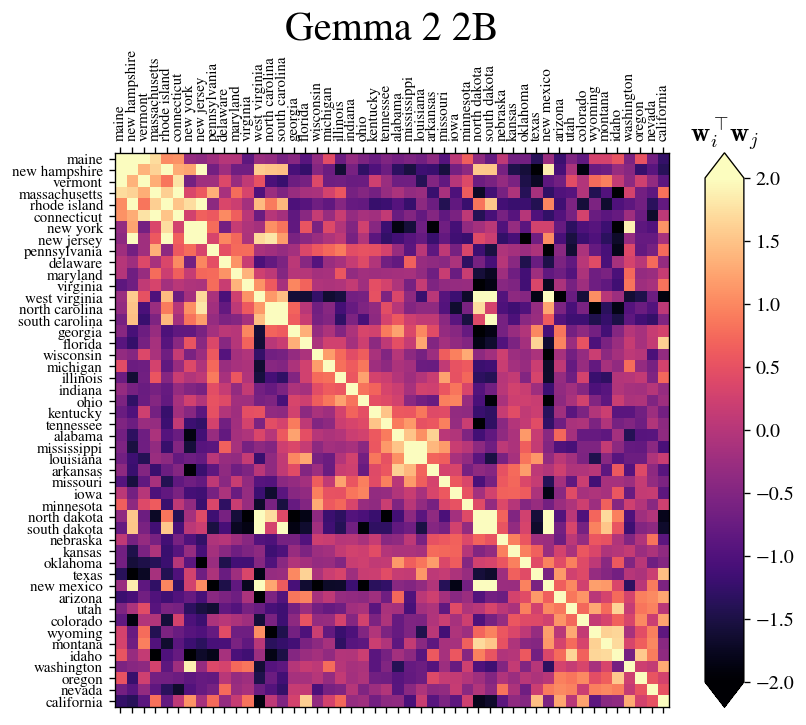

In [16]:
gram = embeds_gemma @ embeds_gemma.T

fig, ax = plt.subplots(figsize=(7, 6))
vmin, vmax = -2, 2
im = ax.matshow(gram, cmap="magma", aspect='equal', vmin=vmin, vmax=vmax)
ax.set_xticks(np.arange(N))
ax.set_yticks(np.arange(N))
ax.set_xticklabels(state_names, rotation=90, fontsize=9)
ax.set_yticklabels(state_names, fontsize=9)
ax.set_aspect('equal')
ax.set_title("Gemma 2 2B", fontsize=24)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="7%", pad=0.3)
cax.set_title(r"$\mathbf{w}_i^\top \! \mathbf{w}_j$", pad=0, fontsize=16)
fig.colorbar(im, cax=cax, extend='both')

plt.show()

## EmbeddingGemma

In [17]:
data = np.load("lm_reps/EmbGemma.npz", allow_pickle=True)
W_gemb = data["arr_2"]

mu = W_gemb.mean(axis=0, keepdims=True)
_, _, Vt = np.linalg.svd(W_gemb - mu, full_matrices=False)
embeds_gemb = (W_gemb - mu) @ Vt.T

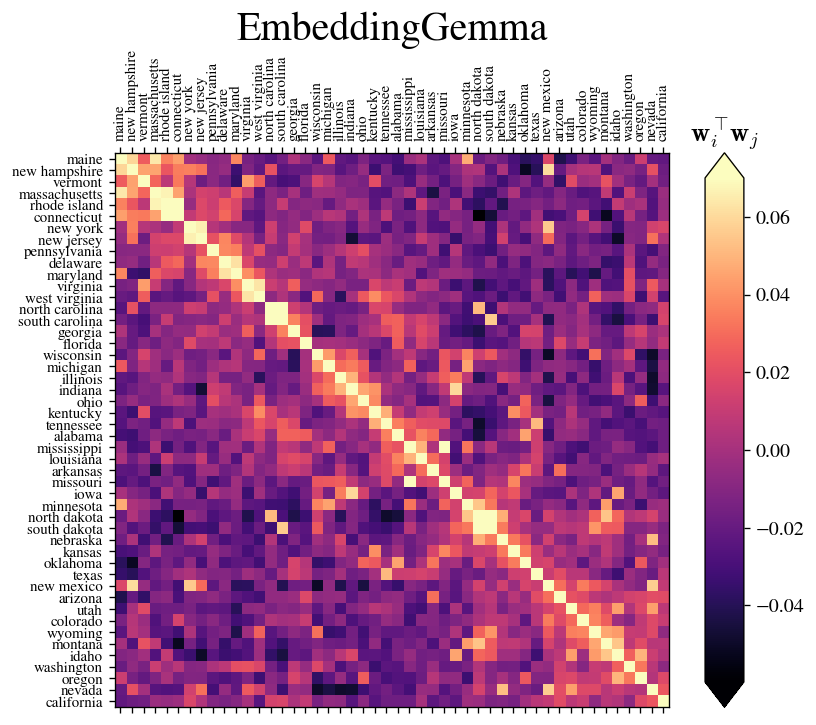

In [18]:
gram = embeds_gemb @ embeds_gemb.T

fig, ax = plt.subplots(figsize=(7, 6))
vmin, vmax = None, .07
im = ax.matshow(gram, cmap="magma", aspect='equal', vmin=vmin, vmax=vmax)
ax.set_xticks(np.arange(N))
ax.set_yticks(np.arange(N))
ax.set_xticklabels(state_names, rotation=90, fontsize=9)
ax.set_yticklabels(state_names, fontsize=9)
ax.set_aspect('equal')
ax.set_title("EmbeddingGemma", fontsize=24)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="7%", pad=0.3)
cax.set_title(r"$\mathbf{w}_i^\top \! \mathbf{w}_j$", pad=0, fontsize=16)
fig.colorbar(im, cax=cax, extend='both')

plt.show()

# Fig 3

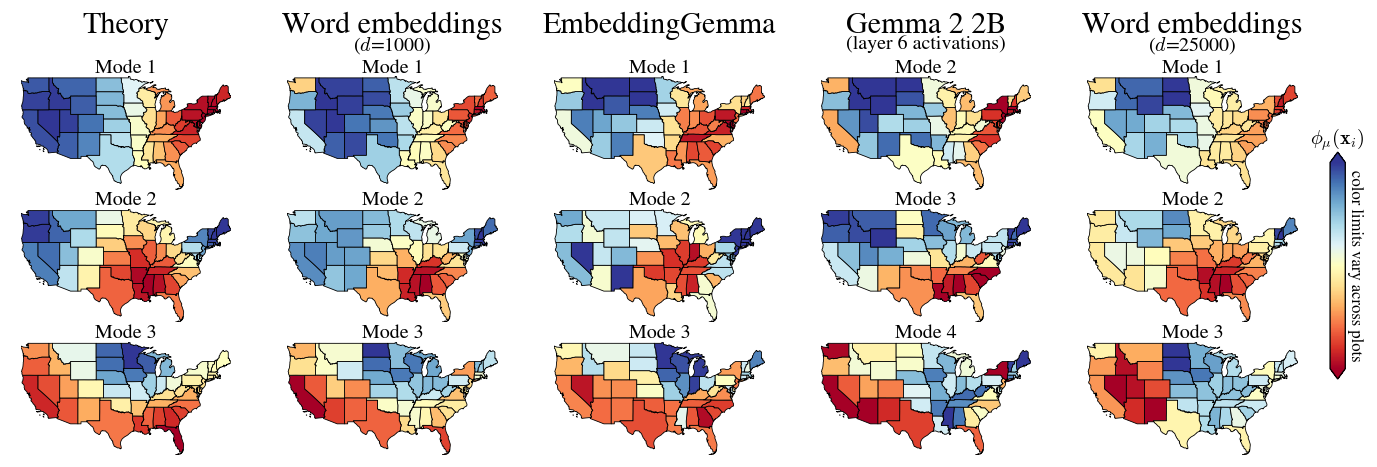

In [19]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig = plt.figure(figsize=(14.5, 4.8))
nrows, ncols = 4, 6
gs = fig.add_gridspec(nrows=nrows, ncols=ncols,
                      height_ratios=[0.4, 1, 1, 1],
                      width_ratios=[3, 3, 3, 3, 3, 0.2])

axes = np.empty((nrows, ncols), dtype=object)
titles = ["Theory", "Word embeddings", "Word embeddings", "Gemma 2 2B", "EmbeddingGemma"]
subtitles = [None, f"($d$=1000)", f"($d$=25000)", "(layer 6 activations)", None]
embeds = [embeds_th, embeds_w2v_1k, embeds_w2v_25k, embeds_gemma, embeds_gemb]
signs = np.array([[1, 1, 1, -1, 1], [-1, 1, -1, -1, 1], [-1, 1, 1, 1, -1]])
dvmin = np.array([[0, 0, 0, 0.3, 0.04], [0, 0, 0, 0.3, -0.01], [0, 0, 0.4, 0.2, -0.01]])
dvmax = np.array([[0, 0, 0, -.3, -0.08], [0, 0, 0, -.6, -0.16], [0, 0, -3.8, -.1, 0]])

shuffle_order = np.array([0, 1, 4, 3, 2])
titles = [titles[i] for i in shuffle_order]
subtitles = [subtitles[i] for i in shuffle_order]
embeds = [embeds[i] for i in shuffle_order]
signs = signs[:, shuffle_order]
dvmin = dvmin[:, shuffle_order]
dvmax = dvmax[:, shuffle_order]

for i in range(nrows):
    for j in range(ncols):
        ax = fig.add_subplot(gs[i, j])
        axes[i, j] = ax
        if j == ncols - 1:
            ax.set_axis_off()
            if i == 2:
                norm = mpl.colors.Normalize(vmin=-1.1, vmax=1.1)
                sm = mpl.cm.ScalarMappable(norm=norm, cmap="RdYlBu")
                
                cax = inset_axes(
                    ax, width="100%", height="200%",
                    loc="center left",
                    bbox_to_anchor=(-1, 0, 1, 1),
                    bbox_transform=ax.transAxes,
                    borderpad=0
                )
                cb = fig.colorbar(sm, cax=cax, extend="both")
                cb.set_ticks([])
                cb.ax.yaxis.set_label_position("right")
                cb.ax.set_ylabel(
                    "color limits vary across plots",
                    fontsize=10, rotation=270, labelpad=6, va="center"
                )
                cb.ax.set_title(f"$\\phi_\\mu(\\mathbf{{x}}_i)$", pad=2, fontsize=12)
            continue
        if i == 0:
            ax.set_axis_off()
            ax.text(0.5, 1, titles[j], rotation=0,
                    ha="center", va="top", fontsize=18)
            ax.text(0.5, 0.5, subtitles[j], rotation=0,
                    ha="center", va="top", fontsize=12)
            continue
        mode_idx = i - 1
        if j == 3:
            mode_idx += 1
        eigfn = signs[i-1,j] * embeds[j][:, mode_idx]
        state_values = {name: eigfn[k] for k, name in enumerate(state_names)}
        vmin, vmax = eigfn.min() + dvmin[i-1,j], eigfn.max() + dvmax[i-1,j]
        
        states50[f"eigenfunction{i}-{j}"] = states50["NAME"].map(state_values)
        states50.plot(column=f"eigenfunction{i}-{j}", cmap="RdYlBu", ax=ax,
                           vmin=vmin, vmax=vmax,
                           edgecolor="black", linewidth=0.5, legend=False)
        ax.margins(0)
        ax.set_title(f"Mode {mode_idx+1}", fontsize=12, pad=-6)
        ax.axis("off")

plt.show()
# fig.subplots_adjust(left=0.01, right=0.99, bottom=0.02, top=0.98)
# plt.savefig("plots/fig3.pdf", dpi=300)